Engine start took 9.248042106628418 seconds


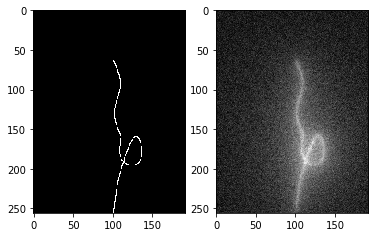

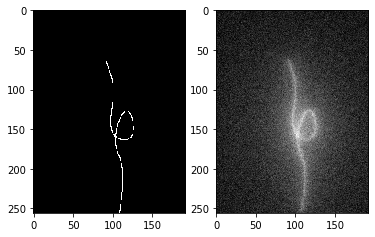

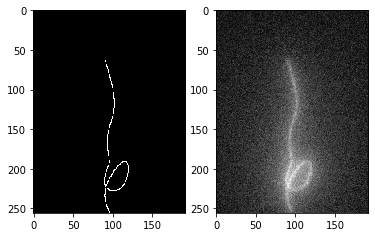

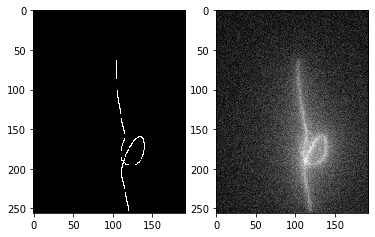

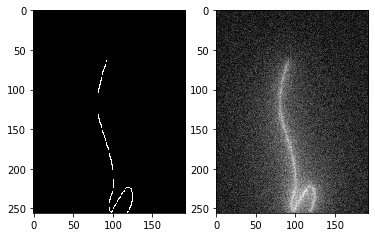

Simulation took 7.005800247192383 seconds


In [12]:
# python -m ipykernel install --user --name=my-virtualenv-name
import matlab.engine
import time
import matplotlib.pyplot as plt
import numpy as np

# Use full browser width
from IPython.core.display import display, HTML
display(HTML(""))

# Show data
eng_start = time.time()
eng = matlab.engine.start_matlab()
print('Engine start took', time.time() - eng_start, 'seconds')

data = []

sim_start = time.time()
for i in range(5):
    ground_truth, simulated = eng.simulate(0, nargout=2)
    
    plt.subplot(121)
    plt.imshow(ground_truth, cmap='gray')
    
    plt.subplot(122)
    plt.imshow(simulated, cmap='gray')
    plt.show()
    
# Most of the time is to set up the connection
print('Simulation took', time.time() - sim_start, 'seconds')

In [27]:
# Generate data
N = 50
train, test = [], []

for i in range(N):
    ground_truth, simulated = eng.simulate(0, nargout=2)
    train += [simulated]
    test += [ground_truth]
    
train, test = np.array(train), np.array(test)

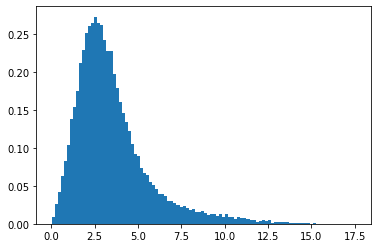

In [28]:
# Look at statistics of data
h2 = plt.hist(train[0].reshape(-1,1), bins = 100, density = True, alpha=1)

# Preprocessing
It might be advantageous to smooth the data and use simple edge detection to crudely highlight the wire
Here we evaluate some preprocessing (but do not yet apply it to the training set)

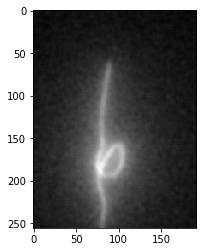

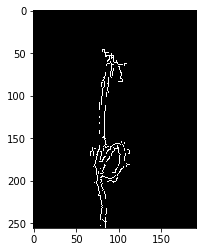

In [29]:
import cv2
ex = train[0]
kernel = np.ones((5,5),np.float32)/(5*5)
ex = cv2.filter2D(ex,-1,kernel)
plt.imshow(ex,cmap = 'gray')
plt.show()

ex = ex - np.min(ex)
ex = 255 * ex / np.max(ex)
ex = np.uint8(ex)
edges = cv2.Canny(ex,20,90)

plt.imshow(edges,cmap = 'gray')
plt.show()

# Intensity-based Segmentation
Here, we use a GMM to do a basic intensity based segmentation

In [85]:
# Segment data
from sklearn.mixture import GaussianMixture
import cv2

# The background and the wire
n_components = 2

model=GaussianMixture(n_components=n_components, means_init=[[0], [5]])

segmentations_gmm = []
segmentations_threshold = []
segmentations_edge = []

for datum in train:

    
    
        
    # Threshold segmentation
    segmentations_threshold += [datum > 10]
    
    # Laplace filter
    lp = -cv2.Laplacian(datum, cv2.CV_64F, ksize=15)
    lp = lp - np.min(lp)
    lp = lp / np.max(lp)
    segmentations_edge += [lp]
#     segmentations_edge += [cv2.Sobel(datum,cv2.CV_64F,1,0,ksize=5)]


## Results
Clearly, the GLM is not very good since the noise can have the same intensity as the wire

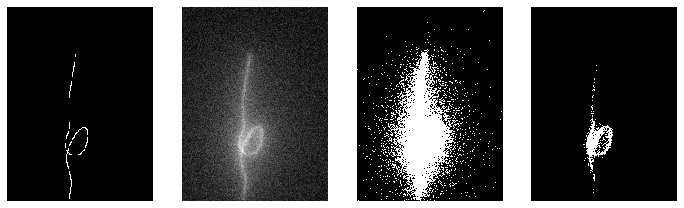

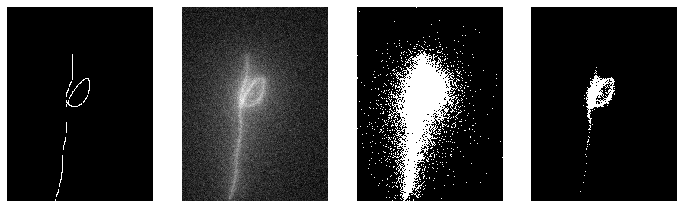

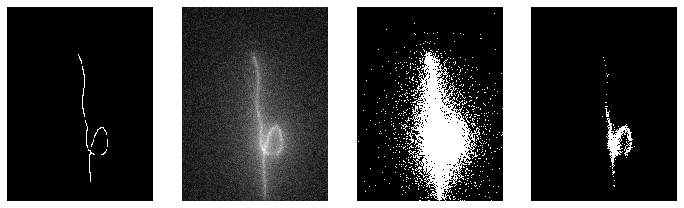

In [86]:
# Show first few segmentations
for i, (seg_gmm, seg_thresh, seg_edge, ground_truth, simulated) in enumerate(list(zip(segmentations_gmm, segmentations_threshold, segmentations_edge, test, train))[:3]):
    plt.figure(figsize=(12, 12))
    plt.subplot(141)
    plt.imshow(ground_truth, cmap='gray')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(simulated, cmap='gray')
    plt.axis('off')

    plt.subplot(143)
    plt.imshow(seg_gmm, cmap='gray')
    plt.axis('off')
    
    plt.subplot(144)
    plt.imshow(seg_thresh, cmap='gray')
    plt.axis('off')
    plt.show()

The Laplace filter followed by a threshold provides very accurate segmenations, with some noise

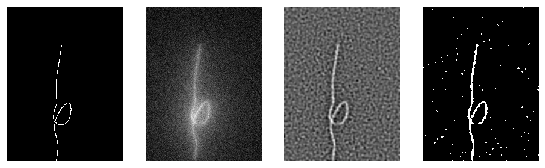

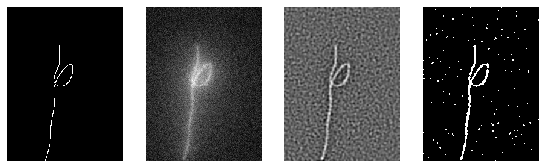

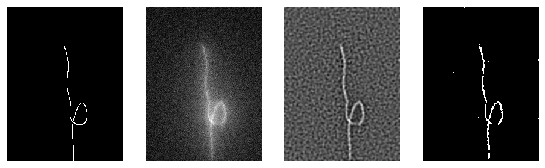

In [94]:
# Show first few segmentations
for i, (seg_edge, ground_truth, simulated) in enumerate(list(zip(segmentations_edge, test, train))[:3]):
    plt.figure(figsize=(12, 12))
    plt.subplot(151)
    plt.imshow(ground_truth, cmap='gray')
    plt.axis('off')

    plt.subplot(152)
    plt.imshow(simulated, cmap='gray')
    plt.axis('off')

    plt.subplot(153)
    plt.imshow(seg_edge, cmap='gray')
    plt.axis('off')
    
    plt.subplot(154)
    plt.imshow(seg_edge > (0.55), cmap='gray')
    plt.axis('off')
    
    plt.show()

# U-Net Segmentation
A more sophisticated approach is needed to segment the wires from the images

In [ ]:
from scipy.spatial.distance import directed_hausdorff
print(directed_hausdorff(test[0], test[0])[0])
print(directed_hausdorff(test[0], test[1])[0])
print(directed_hausdorff(test[1], test[2])[0])